In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as ss
from matplotlib.patches import Rectangle, ConnectionPatch, Arc


In [ ]:
#Import the data: Teams
team=pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\teams.json")
pd.set_option('display.max_rows', 142)
pd.set_option('display.max_columns', 12)
#From index 98, the type is given as Nation. So we don't need that.
team=team[:98]
#convert the area from a series to a list
#Convert the list into a dataframe and concate the dataframe to the parent data i.e. team.
#Drop the column 'area'
team = pd.concat([team,pd.DataFrame(list(team['area']))],axis = 1).drop('area',axis = 1)



# RQ 2

In [ ]:
Matches = pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\matches\matches_England.json")

Premier League Teams can be retrieved from the dataset teams.json with the value 'id' = 0

In [ ]:
PLteams = pd.DataFrame(team[team.id == '0'])
teams = pd.DataFrame({'Name' : list(PLteams.officialName), 'ID' : list(PLteams['wyId'])})
teams
team_data = Matches.teamsData

#### I've chosen to take the two top ranking teams, Manchester City and Manchester Utd., two mid-ranking, Newcastle Utd. and Leicester City and the bottom ranking team of the season, West Bromwich.

In [ ]:
team5 = ['1625', '1611', '1613', '1631', '1627']
print(*[teams[teams['ID'] == int(t)].Name.iloc[0] for t in team5], sep = '\n')

In [ ]:
# Defining a function to display the contingeny tables on the same line with html format
from IPython.display import display_html
def mydisplay(dfs, names=[]):
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center"><strong><em>{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:center"> {df.to_html(index=True)}</td>' 
                         for df in dfs) +
                 '</tr>') 
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)
    

frames = []
for t in team5:   
    a = []
    
    for i in range(len(Matches)):
         if t in list(Matches['teamsData'][i].keys()) :
                
            if str(Matches.winner[i]) == t:
                a.append([team_data[i][t]['side'], 'win'])
                
            elif str(Matches.winner[i]) == '0':
                a.append([team_data[i][t]['side'], 'draw'])
                
            else:
                a.append([team_data[i][t]['side'], 'lose'])
                
    frame = pd.DataFrame(a, columns = ['side', 'result']) 
    
    frames.append(pd.crosstab(frame.side, frame.result))
    
mydisplay(frames, names= [teams[teams['ID'] == int(t)].Name.iloc[0] for t in team5])

In [ ]:
frames = []
Total = []
for t in team5:   
    a = []
    othteam = set(team5)
    othteam.remove(t)
    for i in range(len(Matches)):
         if t in list(Matches['teamsData'][i].keys()) and len(othteam.intersection(set(Matches['teamsData'][i].keys()))) == 0:
            if str(Matches.winner[i]) == t:
                a.append([team_data[i][t]['side'], 'win'])
                Total.append([team_data[i][t]['side'], 'win'])
            elif str(Matches.winner[i]) == '0':
                a.append([team_data[i][t]['side'], 'draw'])
                Total.append([team_data[i][t]['side'], 'draw'])
            else:
                a.append([team_data[i][t]['side'], 'lose'])
                Total.append([team_data[i][t]['side'], 'lose'])
    
    frame = pd.DataFrame(a, columns = ['side', 'result']) 
    frames.append(pd.crosstab(frame.side, frame.result))
mydisplay(frames, names= [teams[teams['ID'] == int(t)].Name.iloc[0] for t in team5])


In [ ]:
Tot = pd.DataFrame(Total, columns=['side', 'result'])
cont_tab = pd.crosstab(Tot.side, Tot.result, margins= True)
cont_tab

## Chi-Squared Test

### A chi-squared test with significance level $\alpha = 0.05$ will now be performed on the contingency table $Side$ x $Result$

#### H0 : The null Hypothesis is that there's no statistically significant relationship between the side on which a team plays and the result of the match

#### H1: The alternative hypotesis is that there's significant relationship between the side of a team and its result in a match

Appending all observed frequencies to a single vector

In [ ]:
f_obs = np.append(cont_tab.iloc[0][0:3].values, cont_tab.iloc[1][0:3].values)
f_obs

Getting the marginal frequencies for rows (Side)

In [ ]:
row_sums = cont_tab.iloc[0:2,3].values
row_sums

Marginal frequencies for columns (Result)

In [ ]:
col_sums = cont_tab.iloc[2,0:3].values
col_sums

Expected frequencies under Indipendence Hypothesis

In [ ]:
total = cont_tab.loc['All', 'All']

f_expected = []
for j in range(2):
    for i in col_sums:
        f_expected.append(i*row_sums[j]/total)
f_expected

$\chi^2$ statistic

In [ ]:
chi_squared_statistic = ((f_obs - f_expected)**2/f_expected).sum()
print('Chi-squared Statistic: {}'.format(chi_squared_statistic))

In [ ]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print("Degrees of Freedom: {}".format(dof))

In [ ]:

percentile = ss.chi2.ppf(0.95, 2)
print('Chi-squared Statistic: {}'.format(round(chi_squared_statistic, 2)),
      '\n95th Percentile of Chi-squared distribution: {}'.format(round(percentile, 2)))

#### Since the Chi-squared statistic obtained from our calculation is bigger than the 95th percentile of the $\chi^2_2$, we can conlude that the null hypotesis must be rejected. There is a relationship between the side on which a team plays and its result in a match, and we can infer, by looking at the following barplot, that playing home influences positively a team's chances of winning a match (likewise, playing away increases chances of losing).

In [ ]:

#Assigns the frequency values
awaycount = cont_tab.iloc[0][0:3].values
homecount = cont_tab.iloc[1][0:3].values

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
results = ["Draw","Lose","Win"]
p1 = plt.bar(results, awaycount, 0.55, color='#d62728')
p2 = plt.bar(results, homecount, 0.55, bottom=awaycount)
plt.legend((p2[0], p1[0]), ('Home','Away'))
plt.xlabel('Results')
plt.ylabel('Count')
plt.show()

# RQ 3

Since we want to find the 10 teams who had the youngest coaches during the whole season, we need to check all of the mathces to see if any team had more than one coach during the season. If that is the case, we will keep only the youngest

#### This information can be found in the teamsData column of Matches dataframe, with the coachId entry

In [ ]:
teams = pd.DataFrame({'Name' : list(PLteams.officialName), 'ID' : list(PLteams['wyId'])})
teams = teams.set_index('ID')

In [ ]:
d = dict()
for t in teams.index:
        d[str(t)] = set()
for i in range(len(Matches)):
    data = pd.DataFrame({'Coach': pd.DataFrame(team_data[i].values())['coachId'], 
                         'Team' : pd.DataFrame(team_data[i].values())['teamId']})
    for t in data.Team:
    #in some matches the coachId is '0', meaning that there's no information, and these values should be removed
        if int(data.Coach[data.Team == t]) != 0:
            d[str(t)].add(int(data.Coach[data.Team == t]))  

#### Just a basic visualization of coach changes for all teams

Making all rows of the same length to avoid creation of NaN values in the dataframe, for a better visualization

In [ ]:
dnew = d.copy()
for i in dnew.keys():
    dnew[i] = list(dnew[i])
    if len(dnew[i]) < 3:
        for _ in range(3-len(dnew[i])):
            dnew[i].append('-')
a = teams.join(pd.DataFrame(dnew.values(), index=map(int, d.keys())))
a

### Now the coaches database must be imported, to match the IDs of Premier league coaches in the dictionary with their corresponding birth dates contained in the database

In [ ]:
coaches = pd.read_json(r'C:\Users\simon\Desktop\ADM Homework 2\coaches.json').drop(['firstName', 'lastName', 'middleName', 'passportArea', 'birthArea'], axis = 1)

#### There's a problem with one of the coaches wyId. It came out that 3782 is not a valid coach ID. In fact, by checking the team to which this ID is associated, Tottenham FC, we can be sure that there should be only one coach wyID (292863), the one associated with Mauricio Pochettino, the only manager of Tottenham since 2014.

In [ ]:
coaches[coaches.wyId == 3782]

In [ ]:
coaches[coaches.wyId == 292863]

#### Changing the dictionary entry of Tottenham FC

In [ ]:
d['1624'] = {292863}

In [ ]:
for i in d.keys():
    bd = []
    for v in d[i]:
        bd.append(coaches.birthDate[coaches.wyId == v].iloc[0])
    bd.sort()
    print(bd)


#### It also came out that Chelsea FC has two coach wyIDs associated to the same manager, Antonio Conte, hence the list with the same date repeated twice. This wouldn't affect our analysis since the two entries in the coaches database are identical, but one of the two wyIDs will be removed to avoid redundancy.

In [ ]:
coaches[coaches.wyId == 272869]

In [ ]:
coaches[coaches.wyId == 20454]

In [ ]:
d['1610'].remove(20454)

#### We can now assign the highest value of the sorted bd (birth date) list to each team's entry in the dictionary, so that we only keep the youngest coach for every team.

In [ ]:
dnew = dict()
for i in d.keys():
    bd = []
    for v in d[i]:
        bd.append(coaches.birthDate[coaches.wyId == v].iloc[0])
    bd.sort()
    dnew[i] = bd[-1]
dnew  

In [ ]:
ordered_DF = pd.DataFrame({'teamID' : list(dnew.keys()), 'Team_Name' : list(teams['Name']),
              'Coach_Birthday' : list(dnew.values())}).sort_values(by = 'Coach_Birthday', ascending=False)

In [ ]:
ordered_DF.reset_index(drop = True, inplace=True)

### The top 10 teams with the youngest coaches feature in the following table

In [ ]:
ordered_DF[0:10]

### Now we want to visualize the distribution of coach ages for the Premier League teams of the 2017/2018 season through a boxplot.

In [ ]:
allcoachesPL = []
for v in d.values():
    allcoachesPL += list(v)
    

In [ ]:
alldates = []
for c in allcoachesPL:
    alldates.append(coaches.birthDate[coaches.wyId == c].iloc[0])    

#### To get the ages of the PL coaches, 2017-12-31 is taken as reference, because it falls in the middle of the 2017/2018 season and makes calculation easier.

In [ ]:
ages = [2017 - int(i[0:4]) for i in alldates]

## Boxplot of the coach ages distribution

In [ ]:
fig = plt.figure(figsize=(7, 5))
sns.set(font_scale=2)
plt.boxplot(ages, labels = ['Premier League Coaches'], patch_artist=True)
plt.ylabel('Ages')
plt.show()
plt.close()

# CRQ 2

To visualize movements and passes of a player on the pitch, I will take the code for drawing a football pitch from **[Towards Data Science](https://towardsdatascience.com/advanced-sports-visualization-with-pandas-matplotlib-and-seaborn-9c16df80a81b)**, and apply some small changes to enhance the result

In [4]:

def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, fill = True, color = (0.3, 1, 0, .2))
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False, color = 'white')
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False, color = 'white')
    midline = ConnectionPatch([60,0], [60,80], "data", "data",  color = 'white')

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False, color = 'white')
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False, color = 'white')


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="white", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="white")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="white")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="white")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="white")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="white")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

In [8]:
events = pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\events\events_Spain.json")
events = events.drop(['eventSec', 'id', 'matchPeriod', 'subEventId', 'subEventName', 'teamId'], axis = 1)

In [6]:
Spa_match = pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\matches\matches_Spain.json")

Retrieving the match on which we want to elaborate the analysis from the dpsin mstches database. We need the match wyId to retrieve corresponding event information from the events database

In [ ]:
Spa_match[Spa_match.label == 'Barcelona - Real Madrid, 2 - 2']

In [ ]:
match_Id = Spa_match[Spa_match.label == 'Barcelona - Real Madrid, 2 - 2'].wyId.iloc[0]

In [ ]:
Bar_ReM = events[events.matchId == match_Id]

In [ ]:
Bar_ReM

We want to visualize with a heatmap the activity areas of Cristiano Ronaldo and Lionel Messi on the pitch during this match, so we need to retrieve their player Id's.

In [20]:
players = pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\players.json")

To be sure to find them, we'll search the database by their last names, which I found on Wikipedia.

In [ ]:
# Messi
players[players.lastName == 'Messi Cuccittini']

In [ ]:
# Ronaldo
players[players.lastName == 'dos Santos Aveiro']

## Ronaldo

In [ ]:
Ron = players[players.lastName == 'dos Santos Aveiro'].wyId.iloc[0]

Extracting the activity information related to Ronaldo from the Events database

In [ ]:
Ron_ev = Bar_ReM[Bar_ReM.playerId == Ron]

Of all the events, we only want to select passes, shoots, duels and free kicks

In [ ]:
Ron_act = Ron_ev[Ron_ev.eventName.isin(['Pass', 'Shot', 'Duel', 'Free Kick'])]

In [ ]:
Ron_act

With a quick glance, we see that the position indicators have two coordinates (x,y), both ranging between 0 and 100. Since length and width of a football pitch should be different, and in our scaled-down version of the pitch we have set the width $"x"$ (long edge) at 120, and the heigth $"y"$ (short edge) at 80, position coordinates from the dataframe must be rescaled.

Moreover, since we have two position values for each event, i.e. the starting and ending point, we must select only the first values, because those are the positions of the player during the game. 

In [ ]:
Ron_pos = Ron_act.positions

In [ ]:
Ron_pos = [Ron_pos.iloc[i][0] for i in range(len(Ron_pos))]

Assigning $"y"$ and $"x"$ coordinates to two different lists, and rescaling values as above said.

In [ ]:
y_coord_Ron = [Ron_pos[i]['y']*80/100 for i in range(len(Ron_pos))]

In [ ]:
x_coord_Ron = [Ron_pos[i]['x']*120/100 for i in range(len(Ron_pos))]

In [ ]:
pd.DataFrame({'y': y_coord_Ron, 'x': x_coord_Ron})

### Plotting the heatmap

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.kdeplot(x_coord_Ron, y_coord_Ron,  cmap = sns.dark_palette("red", as_cmap = True),  n_levels=60, shade=True)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.show()
plt.close()

#### The heatmap shows that Ronaldo was active mostly on the right wing and in front of the net

## Messi

In [ ]:
Mes = players[players.lastName == 'Messi Cuccittini'].wyId.iloc[0]

Extracting the activity information related to Messi from the Events database

In [ ]:
Mes_ev = Bar_ReM[Bar_ReM.playerId == Mes]

Of all the events, we only want to select passes, shoots, duels and free kicks

In [ ]:
Mes_act = Mes_ev[Mes_ev.eventName.isin(['Pass', 'Shot', 'Duel', 'Free Kick'])]

Same as above, we must rescale the coordinates and select only the first values in Positions, to have the positions of Messi on our pitch.

In [ ]:
Mes_pos = Mes_act.positions
Mes_pos = [Mes_pos.iloc[i][0] for i in range(len(Mes_pos))]

y_coord_Mes = [Mes_pos[i]['y']*80/100 for i in range(len(Mes_pos))]

x_coord_Mes = [Mes_pos[i]['x']*120/100 for i in range(len(Mes_pos))]

pd.DataFrame({'y': y_coord_Mes, 'x': x_coord_Mes})

Messi has accomplished more than twice the actions of Cristiano Ronaldo. Good job, Leo!

### Plotting the heatmap

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.kdeplot(x_coord_Mes, y_coord_Mes,  cmap = sns.dark_palette("blue", as_cmap = True),  n_levels= 60, shade=True, cut = 5)
draw_pitch(ax)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.show()
plt.close(fig)

#### The heatmap shows that Messi was active mostly at the center and in central area of the opponent's half of the pitch.

## Mes-aldo






Heatmap of both players. To obtain it, we must reverse the coordinates of one of the players, so that they fall in the right half of the pitch. Ronaldo's coordinates will be reversed.

In [ ]:
xRon = [120 - i for i in x_coord_Ron]
yRon = [80 - i for i in y_coord_Ron]

NameError: name 'xRon' is not defined

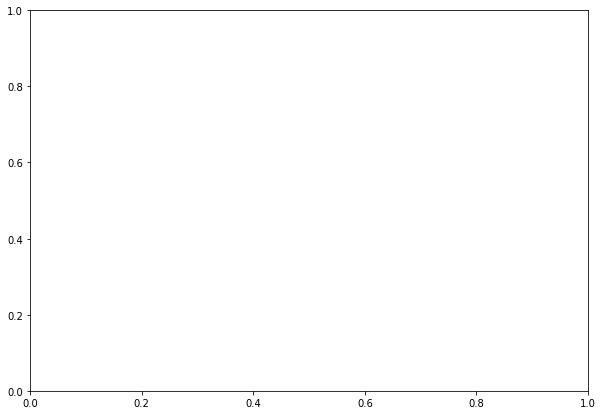

In [15]:

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.kdeplot(xRon, yRon,  cmap = sns.dark_palette("red", as_cmap = True),  n_levels= 50, shade=True, alpha = 1)
sns.kdeplot(x_coord_Mes, y_coord_Mes,  cmap = sns.dark_palette("blue", as_cmap = True),  n_levels= 800, shade=True, cut = 5, alpha = 0.15)
draw_pitch(ax)
sns.set(font_scale=1.3)
leg1 = plt.legend(handles=[mpatches.Patch(color= (.8,.2,0), label='Ronaldo'), mpatches.Patch(color= (0, .2, .8), label='Messi')], loc = 'lower center')
ax = plt.gca().add_artist(leg1)
plt.legend(handles = [mpatches.Patch(color= (0,.2,.8), label='Barcelona'),mpatches.Patch(color= (.8,.2,0), label='Real Madrid')], loc='upper left',
           ncol=2, mode="expand", borderaxespad=-1.8)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.show()
plt.close(fig)


#### As this map shows, Ronaldo's positions are mostly offensive, and almost equally divided between the right wing and the the front of the net. Messi's positions, on the other hand, are mostly central and cover uniformly the  central zone of the opponent's half of the pitch. 

## Juventus - Napoli

In [18]:
Ita_events = pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\events\events_Italy.json")
Ita_events = Ita_events.drop(['eventSec', 'id', 'matchPeriod', 'subEventId', 'subEventName', 'teamId'], axis = 1)

In [10]:
Ita_match = pd.read_json(r"C:\Users\simon\Desktop\ADM Homework 2\matches\matches_Italy.json")

Now we want to visualize passes made by Jorginho and Pjanic during the match Juventus-Napoli through a map of arrows.

In [21]:
Ita_match = Ita_match[Ita_match.label == 'Juventus - Napoli, 0 - 1']

With its wyId we can now retrieve the events related to this match

In [22]:
imatch_Id = Ita_match.wyId.iloc[0]

In [23]:
Juv_Nap = Ita_events[Ita_events.matchId == imatch_Id]

Retrieving playerId's for Jorginho and Pjanic.

In [24]:
players[players.lastName == 'Frello Filho']

,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId
1658,"{'name': 'Brazil', 'id': '76', 'alpha3code': '...",1991-12-20,3757,3187,Jorge Luiz,right,180,Frello Filho,,"{'name': 'Italy', 'id': '380', 'alpha3code': '...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",Jorginho,65,21315


Problem with the encoding of the database characters didn't make possible to find Pjanic through his last name, so we use his first name Miralem, which is luckily quite uncommon.

In [25]:
players[players.firstName == 'Miralem']

,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId
1482,"{'name': 'Bosnia-Herzegovina', 'id': '70', 'al...",1990-04-02,null,3159,Miralem,right,180,Pjani\u0107,,"{'name': 'Luxembourg', 'id': '442', 'alpha3cod...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Pjani\u0107,74,20443


In [26]:
Pja = players[players.firstName == 'Miralem'].wyId.iloc[0]

In [27]:
Jor = players[players.lastName == 'Frello Filho'].wyId.iloc[0]

## Jorginho

In [28]:
Jor_ev = Juv_Nap[Juv_Nap.playerId == Jor]
Jor_passes = Jor_ev[Jor_ev.eventName == 'Pass']
Jor_pas = Jor_passes.positions
Jor_pas = pd.DataFrame({'location' : [i[0] for i in Jor_pas], 'pass_end_location' : [i[1] for i in Jor_pas]})
Jor_pas

,location,pass_end_location
0,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}"
1,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}"
2,"{'y': 72, 'x': 47}","{'y': 96, 'x': 61}"
3,"{'y': 28, 'x': 57}","{'y': 33, 'x': 77}"
4,"{'y': 25, 'x': 61}","{'y': 13, 'x': 74}"
5,"{'y': 23, 'x': 64}","{'y': 20, 'x': 71}"
6,"{'y': 75, 'x': 56}","{'y': 75, 'x': 73}"
7,"{'y': 70, 'x': 27}","{'y': 56, 'x': 27}"
8,"{'y': 63, 'x': 26}","{'y': 52, 'x': 29}"
9,"{'y': 67, 'x': 39}","{'y': 81, 'x': 58}"


In [29]:
def draw_pitch1(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, fill = True, color = (0.3, 1, 0, .7))
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False, color = 'white')
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False, color = 'white')
    midline = ConnectionPatch([60,0], [60,80], "data", "data",  color = 'white')

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False, color = 'white')
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False, color = 'white')



    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="white", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="white")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="white")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="white")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="white")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="white")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

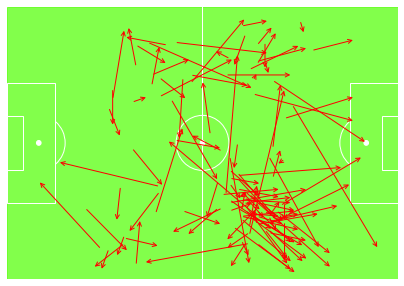

In [30]:
fig=plt.figure() 
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch1(ax)
for i in range(len(Jor_pas)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Jor_pas.iloc[i]['pass_end_location']['x']*120/100, Jor_pas.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Jor_pas.iloc[i]['location']['x']*120/100, Jor_pas.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.show()
ax.clear()
plt.close(fig)


### Jorginho's completed passes

In [31]:
Jor_complete = []
for i in range(len(Jor_passes)):
    if {'id': 1801} in Jor_passes.tags.iloc[i]:
        Jor_complete.append(Jor_passes.iloc[i])

In [32]:
Jor_complete = pd.DataFrame(Jor_complete)
Jor_cpos = pd.DataFrame({'location' : [i[0] for i in Jor_complete.positions], 'pass_end_location' : [i[1] for i in Jor_complete.positions]})

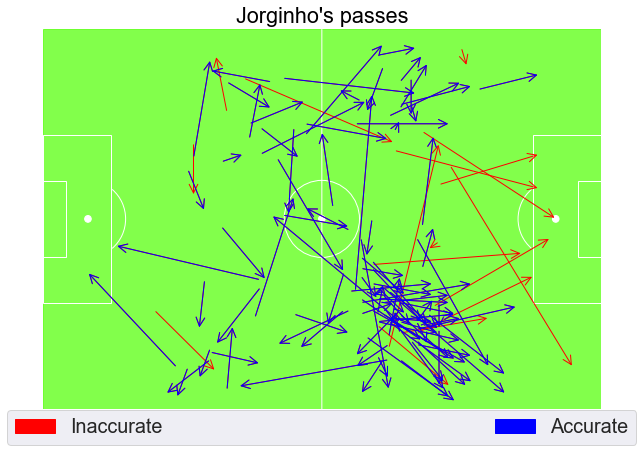

In [33]:
fig=plt.figure() 
fig.set_size_inches(10, 7)
ax=fig.add_subplot(1,1,1)
sns.set(font_scale=1.8)
draw_pitch1(ax)
for i in range(len(Jor_pas)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Jor_pas.iloc[i]['pass_end_location']['x']*120/100, Jor_pas.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Jor_pas.iloc[i]['location']['x']*120/100, Jor_pas.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))
for i in range(len(Jor_cpos)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Jor_cpos.iloc[i]['pass_end_location']['x']*120/100, Jor_cpos.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Jor_cpos.iloc[i]['location']['x']*120/100, Jor_cpos.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
plt.title("Jorginho's passes")
plt.legend(handles = [mpatches.Patch(color= "red", label='Inaccurate'),mpatches.Patch(color= "blue", label='Accurate')], loc='lower left',
           ncol=2, mode="expand", borderaxespad=-1.8)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.show()
ax.clear()
plt.close(fig)


As this graph shows, Jorginho had a good percentage of completed passes over his total passes. It also appears that his passes were mostly succesful on the wings and in short passes, but quite unsuccesful towards the opponent's goal and in longer passes.

## Pjanic

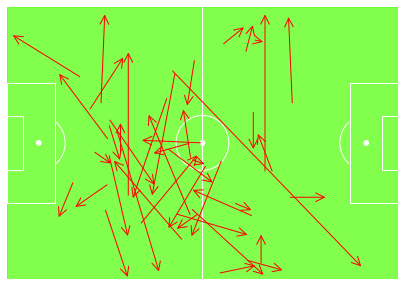

In [34]:
Pja_ev = Juv_Nap[Juv_Nap.playerId == Pja]
Pja_passes = Pja_ev[Pja_ev.eventName == 'Pass']
Pja_pas = Pja_passes.positions
Pja_pas = pd.DataFrame({'location' : [i[0] for i in Pja_pas], 'pass_end_location' : [i[1] for i in Pja_pas]})

fig=plt.figure() 
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch1(ax)
for i in range(len(Pja_pas)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Pja_pas.iloc[i]['pass_end_location']['x']*120/100, Pja_pas.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Pja_pas.iloc[i]['location']['x']*120/100, Pja_pas.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))

plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.show()
ax.clear()
plt.close(fig)


The map of Pjanic's passes looks less dense than Jorginho's. As a matter of fact, Pjanic has carried out less than half of Jorginho's passes.

In [35]:
print("Jorginho's passes : {}".format(len(Jor_passes)), "\nPjanic's passes : {}".format(len(Pja_passes)))

Jorginho's passes : 114 
Pjanic's passes : 44


### Pjanic's completed passes

In [36]:
Pja_complete = []
for i in range(len(Pja_passes)):
    if {'id': 1801} in Pja_passes.tags.iloc[i]:
        Pja_complete.append(Pja_passes.iloc[i])

In [37]:
Pja_complete = pd.DataFrame(Pja_complete)
Pja_cpos = pd.DataFrame({'location' : [i[0] for i in Pja_complete.positions], 'pass_end_location' : [i[1] for i in Pja_complete.positions]})

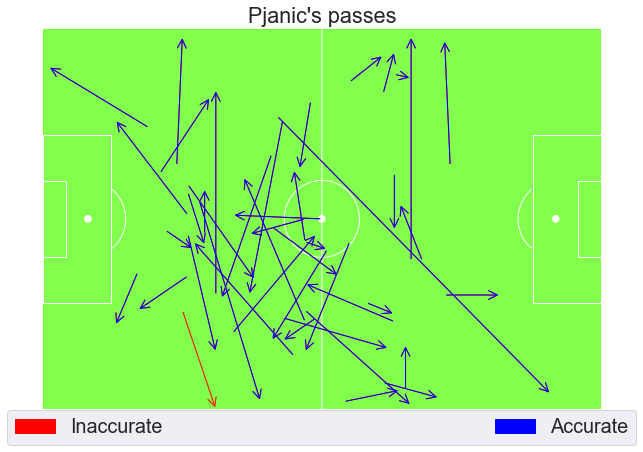

In [38]:
fig=plt.figure() 
fig.set_size_inches(10, 7)
ax=fig.add_subplot(1,1,1)
draw_pitch1(ax)
sns.set(font_scale=1.8)
for i in range(len(Pja_pas)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Pja_pas.iloc[i]['pass_end_location']['x']*120/100, Pja_pas.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Pja_pas.iloc[i]['location']['x']*120/100, Pja_pas.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))

for i in range(len(Pja_cpos)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Pja_cpos.iloc[i]['pass_end_location']['x']*120/100, Pja_cpos.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Pja_cpos.iloc[i]['location']['x']*120/100, Pja_cpos.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.title("Pjanic's passes")
plt.legend(handles = [mpatches.Patch(color= "red", label='Inaccurate'),mpatches.Patch(color= "blue", label='Accurate')], loc='lower left',
           ncol=2, mode="expand", borderaxespad=-1.8)
plt.show()
ax.clear()
plt.close(fig)


### Now a comparison between Pjanic and Jorginho

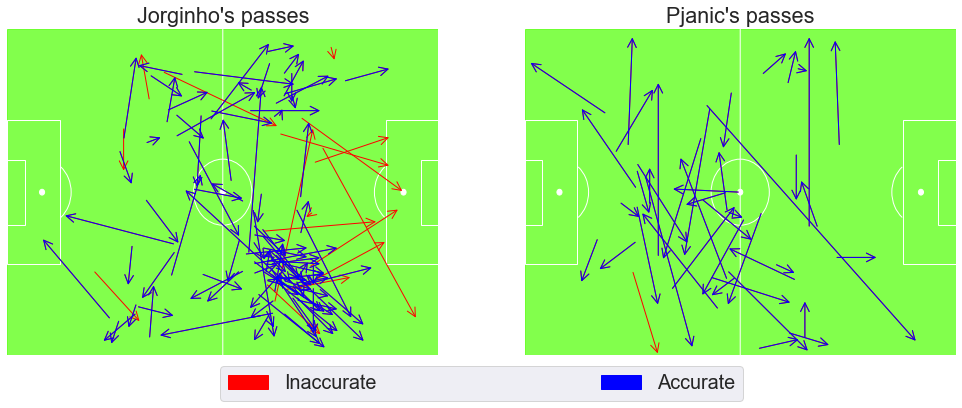

In [130]:
fig=plt.figure() 
fig.set_size_inches(17, 6)
ax=fig.add_subplot(1,2,1)
draw_pitch1(ax)
sns.set(font_scale=1.8)

plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
for i in range(len(Jor_pas)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Jor_pas.iloc[i]['pass_end_location']['x']*120/100, Jor_pas.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Jor_pas.iloc[i]['location']['x']*120/100, Jor_pas.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))
for i in range(len(Jor_cpos)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax.annotate("", xy = (Jor_cpos.iloc[i]['pass_end_location']['x']*120/100, Jor_cpos.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Jor_cpos.iloc[i]['location']['x']*120/100, Jor_cpos.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
plt.title("Jorginho's passes")
plt.legend(handles = [mpatches.Patch(color= "red", label='Inaccurate'),mpatches.Patch(color= "blue", label='Accurate')], loc='lower center',
           ncol=2, mode = 'expand', borderaxespad=-2.3, bbox_to_anchor=(0.6, 0, 1, 1))

ax1=fig.add_subplot(1,2,2)

for i in range(len(Pja_pas)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax1.annotate("", xy = (Pja_pas.iloc[i]['pass_end_location']['x']*120/100, Pja_pas.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Pja_pas.iloc[i]['location']['x']*120/100, Pja_pas.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))

for i in range(len(Pja_cpos)):
    # annotate draw an arrow from a current position to pass_end_location, the coordinates are rescaled as before
    ax1.annotate("", xy = (Pja_cpos.iloc[i]['pass_end_location']['x']*120/100, Pja_cpos.iloc[i]['pass_end_location']['y']*80/100), xycoords = 'data',
               xytext = (Pja_cpos.iloc[i]['location']['x']*120/100, Pja_cpos.iloc[i]['location']['y']*80/100), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
draw_pitch1(ax1)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
plt.title("Pjanic's passes")
plt.show()
ax.clear()
ax1.clear()
plt.close(fig)


#### Although sparser and not localized to a specific area of the pitch, Pjanic had a completion rate of almost 100% for his passes, having carried out only one inaccurate pass during the match. It also appears that Pjanic carried out mostly long passes through the central area of the pitch, often aiming backwards, while Jorginho carried out mostly short passes in the advanced area of the pitch, often aiming onwards. 